In [161]:
from modules import get_trend
from modules import prepare_data
from modules import split_data
from modules import get_data_for_new_predict
from modules import get_new_data
from modules import catboost_split_data
from modules import get_prob_data
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
import optuna

prob_const = 0.6

In [162]:
# Загружаем датасет из файла, форируем модифицированный датасет с установленным индексом по ключу Symbol
data = pd.read_csv("C:/Programs/Projects/IPO/kaggle/input/financial-ipo-data/IPODataFull.csv",
                   encoding="ISO-8859-1", low_memory=False)
data_index = data.set_index('Symbol')

In [163]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

price_start_position = 8
price_stop_position = 1318
price_step = 5
roll_window = 5
diff_step = 2
trend_const = 10
profitably_const = 0.3

In [164]:
# Функция, которая:
# 1. Формирует новый df,состоящий только из цен закрытия за все 262 дня
# 2. Заменяет каждое значение цены средним за предыдущие 5 дней
# 3. Вычисляет разницу 2-х значений усредненных цен с шагом 2, затем сумируем все разницы
# 3. Заменяет каждое значение получившейся серии по условию:
# если сумма отрицательная - бычий тренд, -1, больше 10 - медвежий, 1.
# В ином случае - считаем, что тренд невыраженный, нулевой (то есть за год цена значительно не выросла и не упала).
# После этого функция добавляет к входному датасету новый столбец Trend со значениями тренда
# Также функция добавляет столбец financialResult в котором отражено на сколько процентов изменилась цена
# и столбец is_profit как показатель прибыльности акции
def get_trend(input_df):
    df = input_df.iloc[:, price_start_position:price_stop_position:price_step].copy()
    df = df.rolling(roll_window, axis=1).mean()
    df = df.diff(diff_step, axis=1).sum(axis=1)
    df[df < 0] = -1
    df[(df > 0) & (df <= trend_const)] = 0
    df[df > trend_const] = 1
    df = df.astype(int)
    input_df['trend'] = df
    input_df['financialResult'] = (input_df['closeDay93'] - input_df['closeDay0']) / input_df['closeDay0']
    input_df['is_profit'] = input_df['financialResult'] >= profitably_const
    input_df.is_profit[input_df['is_profit']] = 1
    return 0

get_trend(data_index)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

In [165]:
# Функция предобработки данных. Вычищает спецсимволы, пробелы, приводит численные колонки к типу float,
# убирает пустые значения
def prepare_data(input_df):
    prepared_data = input_df[['MarketCap', 'Industry', 'Revenue', 'netIncome',
                              'employees', 'YearFounded', 'is_profit']].copy()

    prepared_data = prepared_data.replace(r'\$', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(' ', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(',', '.', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\(', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\)', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('B', '0000000', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('M', '0000', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\.', '', regex=True).astype(float)

    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(' ', '', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(',', '.', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('B', '0000000', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('M', '0000', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(r'\.', '', regex=True).astype(float)

    prepared_data[['Industry']] = prepared_data[['Industry']].astype(str)

    prepared_data[['employees']] = prepared_data[['employees']].replace('-', '0', regex=True)
    prepared_data[['employees']] = prepared_data[['employees']].astype(float)

    prepared_data = prepared_data.replace([np.inf, -np.inf], np.nan)
    prepared_data.fillna(0, inplace=True)
    return prepared_data

prepared_df = prepare_data(data_index)

In [166]:
# xx = prepared_df.iloc[:, :6]
# label_encoder = LabelEncoder()
# xx['Encode_Industry'] = label_encoder.fit_transform(xx.iloc[:, 1])
# xx.to_excel("C:/Programs/Projects/IPO/Industry_encoding.xlsx")

In [167]:
# Функция расщепления данных на тренировочный и тетсовый наборы для первичного обучения модели.
# Также перекодирует строковую фичу "Industry".
def split_data(input_df):
    x = input_df.iloc[:, :6]
    y = input_df.is_profit
    label_encoder = LabelEncoder()
    x.iloc[:, 1] = label_encoder.fit_transform(x.iloc[:, 1])
    y.astype(int)
    x_train, x_test, y_tr, y_tes = train_test_split(x, y, random_state=0)
    return x_train, x_test, y_tr, y_tes

X_train, X_test, y_train, y_test = split_data(prepared_df)

In [168]:
# Функция подготовки данных для обучения модели для предсказания новых элементов.
# Не расщепляет исходный датасет для увеличения мощности обучающей выборки.
# Также перекодирует строковую фичу "Industry".
def get_data_for_new_predict(input_df):
    x = input_df.iloc[:, :6]
    y = input_df.is_profit
    label_encoder = LabelEncoder()
    x.iloc[:, 1] = label_encoder.fit_transform(x.iloc[:, 1])
    y.astype(int)
    return x, y

# Готовим полные выборки для предсказания новых IPO
X, y = get_data_for_new_predict(prepared_df)

In [169]:
# Функция, формирующая датафрей с новыми компаниями для предсказания.
def get_new_data(symbol, market_cap, industry, revenue, net_income, employees, year_founded):
    x_new = pd.DataFrame(data={'Symbol': symbol,
                               'MarketCap': market_cap,
                               'Industry': industry,
                               'Revenue': revenue,
                               'netIncome': net_income,
                               'employees': employees,
                               'YearFounded': year_founded})
    x_new = x_new.set_index('Symbol')
    return x_new

X_new = get_new_data(['DLO', 'MQ', 'MNDY', 'ZETA'],
                     [4979640000, 11665500000, 5792900000, 2107930000],
                     [22, 29, 29, 29],
                     [104140000, 290300000, 161100000, 368120000],
                     [28190000, 47700000, -152200000, -53230000],
                     [365, 509, 799, 1296],
                     [2016, 2010, 2012, 2007])

In [170]:
# Изначально былав композиция из 3-х моделей, но по результатам тестирования Catboost всю малину обсирает, 
# поэтому был исключен из финальной версии
# # Оптимизируем модель Catboost на изначальном датасете
# #cat_features = [0, 1]
# train_pool = Pool(X_train, label=y_train)
# test_pool = Pool(X_test, label=y_test)

# best_catboost_model = CatBoostClassifier(
#    bagging_temperature=1,
#    random_strength=1,
#    thread_count=3,
#    iterations=1000,
#    l2_leaf_reg=4.0,
#    learning_rate=0.07521709965938336,
#    random_seed=63,
#    od_type='Iter',
#    od_wait=20,
#    custom_loss=['AUC:hints=skip_train~false'],
#    use_best_model=True
# )

# # Обучаем модель Catboost
# best_catboost_model.fit(
#    train_pool,
#    eval_set=test_pool,
#    logging_level='Silent',
#    plot=True
# )

# # Предсказание Catboost
# catboost_prob = best_catboost_model.predict_proba(X_new)[:, 1]

In [171]:
y_train.value_counts()

0.0    2375
1.0     446
Name: is_profit, dtype: int64

In [172]:
# Функция для оптимизации порога классификации
def threshold_opt(input_predict_proba, y_true):
    thresholds = np.linspace(0, 1, 100)
    scores = [f1_score(y_true, (input_predict_proba > t).astype(np.int)) for t in thresholds]          
    optimal_threshold = thresholds[scores.index(max(scores))]
    y_pred_opt_thres = (input_predict_proba > optimal_threshold).astype(np.int)
    return optimal_threshold, y_pred_opt_thres

In [173]:
# Функция для оптимизации гиперпараметров для LightGBM
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "rf"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 1002, 100),
        "n_estimators": trial.suggest_int("n_estimators", 2, 1002, 100),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 100000, 500000, 1000),
    }

    lgbm = lgb.LGBMClassifier(**param)
    lgbm.fit(X_train, y_train)
    predictions_proba = lgbm.predict_proba(X_test)[:, 1]
    opt_thres, y_predict_opt_thres = threshold_opt(predictions_proba, y_test)
    accuracy = f1_score(y_test, y_predict_opt_thres, average='weighted')
    return accuracy


# Обучаем модель LightGBM, оптимизируя гиперпараметры с помощью Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=False)
best_lgb_parameters = study.best_params
best_lgb_clf = lgb.LGBMClassifier(**study.best_params)

best_lgb_clf.fit(X, y)

lgb_prob = best_lgb_clf.predict_proba(X_new)[:, 1]
lgb_prob

[I 2021-06-09 10:11:28,626] A new study created in memory with name: no-name-aa404d6f-ff92-4302-ad6d-b26bb932cdbb
[I 2021-06-09 10:11:42,886] Trial 3 finished with value: 0.469222315100939 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0002957597915158111, 'lambda_l2': 0.00018849353141971273, 'num_leaves': 90, 'feature_fraction': 0.5548983654012463, 'bagging_fraction': 0.8087353521569498, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 202, 'n_estimators': 2, 'subsample_for_bin': 398000}. Best is trial 3 with value: 0.469222315100939.
[I 2021-06-09 10:11:42,981] Trial 2 finished with value: 0.5008124202033187 and parameters: {'boosting_type': 'rf', 'lambda_l1': 0.009198011042894732, 'lambda_l2': 4.860667580611887e-06, 'num_leaves': 28, 'feature_fraction': 0.6705086532601132, 'bagging_fraction': 0.4477102378469304, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 1002, 'n_estimators': 502, 'subsample_for_bin': 220000}. Best is trial 2 with value: 0.50081242020

[I 2021-06-09 10:11:55,495] Trial 20 finished with value: 0.6687110424326443 and parameters: {'boosting_type': 'rf', 'lambda_l1': 1.0495122902360849e-05, 'lambda_l2': 3.409994703762443, 'num_leaves': 12, 'feature_fraction': 0.8129099444204738, 'bagging_fraction': 0.590869483251087, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 2, 'n_estimators': 902, 'subsample_for_bin': 484000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:11:56,654] Trial 21 finished with value: 0.7102894546627168 and parameters: {'boosting_type': 'rf', 'lambda_l1': 7.046182664904548e-06, 'lambda_l2': 8.562546274117429, 'num_leaves': 6, 'feature_fraction': 0.991777015968871, 'bagging_fraction': 0.5890067313926859, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 702, 'n_estimators': 902, 'subsample_for_bin': 484000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:11:57,492] Trial 0 finished with value: 0.6200064638800414 and parameters: {'boosting_type': 'dart',

[I 2021-06-09 10:12:08,364] Trial 36 finished with value: 0.5960844538966139 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.15775973650133e-06, 'lambda_l2': 0.0009085036119508607, 'num_leaves': 19, 'feature_fraction': 0.7403854523537376, 'bagging_fraction': 0.6395103471680872, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 602, 'n_estimators': 902, 'subsample_for_bin': 498000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:12:09,517] Trial 38 finished with value: 0.585657047267459 and parameters: {'boosting_type': 'rf', 'lambda_l1': 2.0166995052903755e-08, 'lambda_l2': 1.2104287662858292e-05, 'num_leaves': 158, 'feature_fraction': 0.8077988766930564, 'bagging_fraction': 0.6172931185880058, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 902, 'n_estimators': 702, 'subsample_for_bin': 495000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:12:10,055] Trial 37 finished with value: 0.7015350047740576 and parameters: {'boosti

[I 2021-06-09 10:12:23,457] Trial 56 finished with value: 0.5526122736395633 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.07969005783368782, 'lambda_l2': 1.619310615189774e-08, 'num_leaves': 80, 'feature_fraction': 0.7814345472492065, 'bagging_fraction': 0.412937148595424, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 802, 'n_estimators': 302, 'subsample_for_bin': 454000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:12:23,637] Trial 58 finished with value: 0.49304296370842876 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.1950195960339871, 'lambda_l2': 1.8792308900180417e-07, 'num_leaves': 77, 'feature_fraction': 0.7713537733037366, 'bagging_fraction': 0.4183450913265811, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 802, 'n_estimators': 302, 'subsample_for_bin': 170000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:12:24,095] Trial 55 finished with value: 0.5459794295149251 and parameters: {'boosting_

[I 2021-06-09 10:12:33,226] Trial 60 finished with value: 0.4987691713935493 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.06007692872103377, 'lambda_l2': 6.460035345804367e-08, 'num_leaves': 44, 'feature_fraction': 0.7696909788600235, 'bagging_fraction': 0.7790567846518549, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 802, 'n_estimators': 602, 'subsample_for_bin': 458000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:12:33,831] Trial 72 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.0012423029065880672, 'lambda_l2': 2.2761519716995613e-08, 'num_leaves': 68, 'feature_fraction': 0.8856411156489278, 'bagging_fraction': 0.6718230823126916, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 902, 'n_estimators': 602, 'subsample_for_bin': 111000}. Best is trial 9 with value: 0.7432616640540568.
[I 2021-06-09 10:12:34,338] Trial 73 finished with value: 0.7026532916840084 and parameters: {'boost

[I 2021-06-09 10:12:44,305] Trial 90 finished with value: 0.7428117217031633 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.7186856399209223e-07, 'lambda_l2': 0.00022029947493047215, 'num_leaves': 99, 'feature_fraction': 0.5507012418789908, 'bagging_fraction': 0.6164697845995404, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 702, 'n_estimators': 502, 'subsample_for_bin': 390000}. Best is trial 79 with value: 0.748314978508226.
[I 2021-06-09 10:12:44,578] Trial 91 finished with value: 0.7620483312110842 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.485688217762365e-07, 'lambda_l2': 0.0037482965970396173, 'num_leaves': 83, 'feature_fraction': 0.6361156609345043, 'bagging_fraction': 0.6119710432767127, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 702, 'n_estimators': 502, 'subsample_for_bin': 392000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:12:44,940] Trial 92 finished with value: 0.7075018112516951 and parameters: {'boos

[I 2021-06-09 10:12:52,583] Trial 108 finished with value: 0.7219875267641177 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.947482372452139e-08, 'lambda_l2': 0.004196557356939383, 'num_leaves': 131, 'feature_fraction': 0.41850823861940467, 'bagging_fraction': 0.83040104667592, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 602, 'n_estimators': 502, 'subsample_for_bin': 409000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:12:52,986] Trial 109 finished with value: 0.7304628661036286 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.582133872823052e-08, 'lambda_l2': 0.004752786670859896, 'num_leaves': 130, 'feature_fraction': 0.5208640368177351, 'bagging_fraction': 0.7352866551586162, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 602, 'n_estimators': 502, 'subsample_for_bin': 412000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:12:52,993] Trial 110 finished with value: 0.7123448731056592 and parameters: {'b

[I 2021-06-09 10:13:02,523] Trial 126 finished with value: 0.7269642861490488 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.347596964577821e-07, 'lambda_l2': 0.0006155539806365161, 'num_leaves': 181, 'feature_fraction': 0.48125287410935447, 'bagging_fraction': 0.8623282169071625, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 402, 'n_estimators': 602, 'subsample_for_bin': 422000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:13:02,959] Trial 127 finished with value: 0.7303067991640128 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.6194275229432382e-07, 'lambda_l2': 0.00064556564515672, 'num_leaves': 143, 'feature_fraction': 0.48030751607506555, 'bagging_fraction': 0.8668008497369343, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 402, 'n_estimators': 702, 'subsample_for_bin': 452000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:13:03,321] Trial 128 finished with value: 0.7389201064782477 and parameters:

[I 2021-06-09 10:13:12,520] Trial 144 finished with value: 0.736551480896986 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.158182393021384e-06, 'lambda_l2': 0.00015574123525325878, 'num_leaves': 195, 'feature_fraction': 0.421300651924145, 'bagging_fraction': 0.9399370956286516, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 302, 'n_estimators': 802, 'subsample_for_bin': 466000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:13:13,378] Trial 145 finished with value: 0.7358029516552591 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.1092413392096766e-06, 'lambda_l2': 6.891370975001731e-05, 'num_leaves': 191, 'feature_fraction': 0.4354267740598817, 'bagging_fraction': 0.974800940983906, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 302, 'n_estimators': 802, 'subsample_for_bin': 400000}. Best is trial 91 with value: 0.7620483312110842.
[I 2021-06-09 10:13:13,787] Trial 146 finished with value: 0.7361793103299495 and parameters: {

[I 2021-06-09 10:13:22,336] Trial 162 finished with value: 0.7255300686285886 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.2643186474133319e-05, 'lambda_l2': 8.513884811545415e-05, 'num_leaves': 185, 'feature_fraction': 0.4500011767783825, 'bagging_fraction': 0.9037800100413281, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 402, 'n_estimators': 802, 'subsample_for_bin': 446000}. Best is trial 149 with value: 0.7740886858585158.
[I 2021-06-09 10:13:22,813] Trial 163 finished with value: 0.739320508555895 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.269031088844191e-06, 'lambda_l2': 0.0018049441028622514, 'num_leaves': 186, 'feature_fraction': 0.49187614926946116, 'bagging_fraction': 0.9935019740423412, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 402, 'n_estimators': 802, 'subsample_for_bin': 444000}. Best is trial 149 with value: 0.7740886858585158.
[I 2021-06-09 10:13:23,201] Trial 164 finished with value: 0.7302413353074471 and parameter

[I 2021-06-09 10:13:37,577] Trial 183 finished with value: 0.7623340428469499 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.6772112009760995e-07, 'lambda_l2': 5.121290371692887e-06, 'num_leaves': 229, 'feature_fraction': 0.45923534141759004, 'bagging_fraction': 0.8936930262295365, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 460000}. Best is trial 149 with value: 0.7740886858585158.
[I 2021-06-09 10:13:37,834] Trial 182 finished with value: 0.7463410470748507 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.97800720952832e-07, 'lambda_l2': 6.776991548330443e-06, 'num_leaves': 230, 'feature_fraction': 0.4222997865310442, 'bagging_fraction': 0.8191790267995629, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 461000}. Best is trial 149 with value: 0.7740886858585158.
[I 2021-06-09 10:13:37,997] Trial 181 finished with value: 0.7478201554125901 and parameter

[I 2021-06-09 10:14:04,482] Trial 201 finished with value: 0.7498762317769332 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.73997084785554e-07, 'lambda_l2': 1.072099172559701e-05, 'num_leaves': 211, 'feature_fraction': 0.5128643444365029, 'bagging_fraction': 0.9106550069088916, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 479000}. Best is trial 149 with value: 0.7740886858585158.
[I 2021-06-09 10:14:05,029] Trial 195 finished with value: 0.605347339318597 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0522944414763926e-07, 'lambda_l2': 2.6712458753556594e-06, 'num_leaves': 220, 'feature_fraction': 0.47420919451724763, 'bagging_fraction': 0.831308919599195, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 432000}. Best is trial 149 with value: 0.7740886858585158.
[I 2021-06-09 10:14:06,069] Trial 194 finished with value: 0.698357761789869 and parameters:

[I 2021-06-09 10:14:16,807] Trial 216 finished with value: 0.7431688319870745 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.1272059201417704e-07, 'lambda_l2': 9.890292175761058e-07, 'num_leaves': 244, 'feature_fraction': 0.5012386413471438, 'bagging_fraction': 0.8870676801991894, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 497000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:17,717] Trial 217 finished with value: 0.7478201554125901 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.497871054576262e-07, 'lambda_l2': 8.424204528731554e-07, 'num_leaves': 245, 'feature_fraction': 0.505500975947211, 'bagging_fraction': 0.8859780343296784, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 409000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:17,936] Trial 218 finished with value: 0.7471585826486559 and paramete

[I 2021-06-09 10:14:27,640] Trial 234 finished with value: 0.7677464887877509 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.1539294108990045e-07, 'lambda_l2': 6.79095176803915e-06, 'num_leaves': 240, 'feature_fraction': 0.48270389350909276, 'bagging_fraction': 0.7919764631458182, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 422000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:28,121] Trial 235 finished with value: 0.7454951737821178 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.3817853540808016e-07, 'lambda_l2': 5.09248324792171e-06, 'num_leaves': 241, 'feature_fraction': 0.5227079848928129, 'bagging_fraction': 0.8544261894474644, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 397000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:28,901] Trial 236 finished with value: 0.7579994628246711 and paramet

[I 2021-06-09 10:14:37,758] Trial 251 finished with value: 0.7620999789810013 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.560438403388282e-06, 'lambda_l2': 7.409298251989582e-06, 'num_leaves': 207, 'feature_fraction': 0.4976521368397844, 'bagging_fraction': 0.9281100278544596, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 378000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:38,418] Trial 252 finished with value: 0.7507855655128697 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.3846350139805047e-06, 'lambda_l2': 6.784111655498933e-06, 'num_leaves': 228, 'feature_fraction': 0.4991831998725174, 'bagging_fraction': 0.9268386990805144, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 399000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:38,773] Trial 253 finished with value: 0.7692264025267226 and parameter

[I 2021-06-09 10:14:49,088] Trial 268 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 9.46226119307886e-07, 'lambda_l2': 2.6730561096956197e-06, 'num_leaves': 194, 'feature_fraction': 0.5290021449926263, 'bagging_fraction': 0.9157789378076526, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 427000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:49,776] Trial 275 finished with value: 0.5670685934235655 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.5099105644757836e-06, 'lambda_l2': 2.932572093079448e-06, 'num_leaves': 191, 'feature_fraction': 0.533607418854122, 'bagging_fraction': 0.9237982201108205, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 2, 'n_estimators': 902, 'subsample_for_bin': 427000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:14:51,494] Trial 271 finished with value: 0.7473803572806773 and parameters:

[I 2021-06-09 10:15:02,539] Trial 286 finished with value: 0.5948242750635038 and parameters: {'boosting_type': 'rf', 'lambda_l1': 5.246505448178491e-07, 'lambda_l2': 4.875809734133822e-06, 'num_leaves': 247, 'feature_fraction': 0.4767241512417778, 'bagging_fraction': 0.9579729218551403, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 433000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:02,717] Trial 289 finished with value: 0.7467821207821528 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.369098377492031e-07, 'lambda_l2': 4.621388272340856e-06, 'num_leaves': 248, 'feature_fraction': 0.5656680767435303, 'bagging_fraction': 0.8772577673244525, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 448000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:03,250] Trial 290 finished with value: 0.04328988290809114 and parameter

[I 2021-06-09 10:15:13,441] Trial 306 finished with value: 0.753949244629268 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.397352797713376e-06, 'lambda_l2': 2.9147658716722934e-06, 'num_leaves': 237, 'feature_fraction': 0.5062467114676529, 'bagging_fraction': 0.9200172956118975, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 401000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:14,130] Trial 308 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.595474435256955e-06, 'lambda_l2': 2.703566211062617e-06, 'num_leaves': 237, 'feature_fraction': 0.5181250176263118, 'bagging_fraction': 0.938623362737457, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 402000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:14,212] Trial 307 finished with value: 0.746478156448933 and parameters: 

[I 2021-06-09 10:15:24,178] Trial 324 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.033271085896602e-07, 'lambda_l2': 1.0178189599422995e-06, 'num_leaves': 205, 'feature_fraction': 0.5853390454302378, 'bagging_fraction': 0.9038328483202235, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 424000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:24,998] Trial 325 finished with value: 0.7581906853399469 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.827990943623204e-07, 'lambda_l2': 8.275292962366411e-07, 'num_leaves': 203, 'feature_fraction': 0.45994338523516054, 'bagging_fraction': 0.8992478180141185, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 463000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:25,523] Trial 332 finished with value: 0.6494903060233156 and param

[I 2021-06-09 10:15:35,930] Trial 346 finished with value: 0.5991195451984718 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.1110201144450266e-06, 'lambda_l2': 6.412890457828403e-06, 'num_leaves': 196, 'feature_fraction': 0.4521394437080301, 'bagging_fraction': 0.8907448613130371, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 454000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:36,174] Trial 342 finished with value: 0.7474757560873151 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.273625117752252e-06, 'lambda_l2': 6.182649816574946e-06, 'num_leaves': 197, 'feature_fraction': 0.4440490787455889, 'bagging_fraction': 0.8699934621214247, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 102, 'n_estimators': 802, 'subsample_for_bin': 442000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:37,078] Trial 343 finished with value: 0.7470453001402956 and parameters

[I 2021-06-09 10:15:50,511] Trial 358 finished with value: 0.7434020951906093 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.3890091120984919e-07, 'lambda_l2': 1.9995833814672438e-06, 'num_leaves': 206, 'feature_fraction': 0.4689720913257832, 'bagging_fraction': 0.8519483460824082, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 473000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:52,644] Trial 359 finished with value: 0.7613341935153455 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.4542851047433728e-07, 'lambda_l2': 1.8902234776738474e-06, 'num_leaves': 207, 'feature_fraction': 0.46859698539152655, 'bagging_fraction': 0.9720516508046677, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 460000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:15:53,398] Trial 362 finished with value: 0.7603002468156301 and par

[I 2021-06-09 10:16:06,631] Trial 378 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.1823781354551704e-06, 'lambda_l2': 2.4375524116094326e-06, 'num_leaves': 232, 'feature_fraction': 0.45605855227113923, 'bagging_fraction': 0.991563816392062, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 482000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:16:07,418] Trial 382 finished with value: 0.6372323290936052 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.9382439247657495e-06, 'lambda_l2': 5.025255587803015e-06, 'num_leaves': 256, 'feature_fraction': 0.5059604634194715, 'bagging_fraction': 0.992795244028433, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 2, 'n_estimators': 902, 'subsample_for_bin': 386000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:16:09,760] Trial 383 finished with value: 0.6428758752900594 and parameter

[I 2021-06-09 10:16:40,359] Trial 390 finished with value: 0.6881102031900874 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.7241087262665772e-06, 'lambda_l2': 1.613189013164314e-05, 'num_leaves': 243, 'feature_fraction': 0.4931040347502245, 'bagging_fraction': 0.9213390566724823, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 419000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:16:40,758] Trial 391 finished with value: 0.734232294170023 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.8424106044447963e-06, 'lambda_l2': 1.6148661746276935e-05, 'num_leaves': 244, 'feature_fraction': 0.48957943221707034, 'bagging_fraction': 0.9516533833157725, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 420000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:16:41,878] Trial 404 finished with value: 0.5560678278315452 and param

[I 2021-06-09 10:16:52,153] Trial 415 finished with value: 0.7451444563564046 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.0457039019032096e-07, 'lambda_l2': 3.317329786074477e-06, 'num_leaves': 202, 'feature_fraction': 0.5413821564238159, 'bagging_fraction': 0.9117288800825264, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 460000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:16:52,918] Trial 419 finished with value: 0.7122460090021361 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.5500096729451653e-08, 'lambda_l2': 3.3573434203680273e-06, 'num_leaves': 252, 'feature_fraction': 0.47461078729639106, 'bagging_fraction': 0.9160880607525502, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 102, 'n_estimators': 302, 'subsample_for_bin': 461000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:16:54,587] Trial 417 finished with value: 0.737734298270005 and paramet

[I 2021-06-09 10:17:05,062] Trial 434 finished with value: 0.6148980670206553 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 5.45546072709143e-06, 'lambda_l2': 1.5063314266308167e-06, 'num_leaves': 196, 'feature_fraction': 0.49548280303718595, 'bagging_fraction': 0.8864327568974009, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 382000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:05,479] Trial 430 finished with value: 0.7258361755897454 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.2881028042777582e-06, 'lambda_l2': 8.284882622681856e-07, 'num_leaves': 195, 'feature_fraction': 0.41380238806825265, 'bagging_fraction': 0.5687628680708214, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 437000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:06,046] Trial 436 finished with value: 0.5638510717030473 and paramet

[I 2021-06-09 10:17:19,274] Trial 450 finished with value: 0.7551032982885765 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.965319130202941e-07, 'lambda_l2': 5.668849333669718e-06, 'num_leaves': 248, 'feature_fraction': 0.4843386514818961, 'bagging_fraction': 0.8896508927974645, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 369000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:19,831] Trial 451 finished with value: 0.7501439814266502 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.370904565015704e-07, 'lambda_l2': 4.973338980131375e-06, 'num_leaves': 249, 'feature_fraction': 0.5265366601342903, 'bagging_fraction': 0.8979695848705274, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 408000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:20,986] Trial 452 finished with value: 0.7457093506507332 and paramete

[I 2021-06-09 10:17:31,894] Trial 468 finished with value: 0.7454951737821178 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.9915517074004881e-07, 'lambda_l2': 3.588347489013351e-06, 'num_leaves': 240, 'feature_fraction': 0.5517494171178101, 'bagging_fraction': 0.964864223699793, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 444000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:32,791] Trial 469 finished with value: 0.7411932076177443 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.3319853588680196e-07, 'lambda_l2': 8.907844031296021e-06, 'num_leaves': 242, 'feature_fraction': 0.462297213972748, 'bagging_fraction': 0.9627152589125296, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 442000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:33,338] Trial 472 finished with value: 0.7247280334675357 and paramete

[I 2021-06-09 10:17:45,492] Trial 485 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.1289976123305168e-06, 'lambda_l2': 1.771464426726894e-06, 'num_leaves': 226, 'feature_fraction': 0.4974385702759594, 'bagging_fraction': 0.9218159366864269, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 119000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:45,847] Trial 484 finished with value: 0.759037050462215 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 9.488541842592172e-07, 'lambda_l2': 4.5947790861217625e-05, 'num_leaves': 200, 'feature_fraction': 0.49417471811650393, 'bagging_fraction': 0.8670332950826368, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 460000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:46,189] Trial 488 finished with value: 0.6476054919638092 and paramet

[I 2021-06-09 10:17:58,487] Trial 505 finished with value: 0.7319336849442465 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.242217999282078e-07, 'lambda_l2': 4.15944977652733e-06, 'num_leaves': 93, 'feature_fraction': 0.5765622203444482, 'bagging_fraction': 0.8801262072212761, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 431000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:58,920] Trial 504 finished with value: 0.7392175832484139 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.0003164190581310406, 'lambda_l2': 4.082134777121935e-06, 'num_leaves': 217, 'feature_fraction': 0.5756553787441114, 'bagging_fraction': 0.8784450903660723, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 802, 'n_estimators': 902, 'subsample_for_bin': 487000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:17:59,228] Trial 506 finished with value: 0.7474757560873151 and parameters: 

[I 2021-06-09 10:18:07,959] Trial 519 finished with value: 0.7435894716661648 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.464505617536301e-07, 'lambda_l2': 7.494340071587383e-06, 'num_leaves': 210, 'feature_fraction': 0.5105057002647306, 'bagging_fraction': 0.9108043924831971, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 453000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:08,695] Trial 520 finished with value: 0.7447825131077368 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.467164460307886e-07, 'lambda_l2': 7.127962214580158e-06, 'num_leaves': 205, 'feature_fraction': 0.5132978557926717, 'bagging_fraction': 0.9088918155885277, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 427000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:09,352] Trial 521 finished with value: 0.04328988290809114 and parameter

[I 2021-06-09 10:18:21,994] Trial 541 finished with value: 0.7428452659814864 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.1063463657588203, 'lambda_l2': 0.0019831127698398568, 'num_leaves': 237, 'feature_fraction': 0.46451499043664973, 'bagging_fraction': 0.8984932699480439, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 388000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:22,788] Trial 540 finished with value: 0.7522170984262224 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.145752741404796e-06, 'lambda_l2': 4.640588685414071e-06, 'num_leaves': 237, 'feature_fraction': 0.46314911983658696, 'bagging_fraction': 0.8965254308001703, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 469000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:23,038] Trial 542 finished with value: 0.7592547873154232 and parameter

[I 2021-06-09 10:18:32,318] Trial 556 finished with value: 0.736584339930229 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.400452231378971e-06, 'lambda_l2': 3.7047278411213556e-06, 'num_leaves': 245, 'feature_fraction': 0.40747826479690885, 'bagging_fraction': 0.9197878477825806, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 474000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:33,361] Trial 559 finished with value: 0.7531855802729548 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 9.948835725585964e-06, 'lambda_l2': 3.007552646313828e-06, 'num_leaves': 246, 'feature_fraction': 0.4234962210523069, 'bagging_fraction': 0.8831570309481418, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 492000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:33,612] Trial 560 finished with value: 0.7486777188066289 and paramet

[I 2021-06-09 10:18:42,978] Trial 576 finished with value: 0.7134643765294678 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.6191425055149542e-06, 'lambda_l2': 5.065286159473902e-06, 'num_leaves': 234, 'feature_fraction': 0.4011619451694349, 'bagging_fraction': 0.854587695831621, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 498000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:43,802] Trial 577 finished with value: 0.7609795270452911 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.788255581742154e-05, 'lambda_l2': 5.067757887867418e-06, 'num_leaves': 232, 'feature_fraction': 0.43718452666238033, 'bagging_fraction': 0.8584921736010862, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 495000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:18:44,444] Trial 578 finished with value: 0.7420641394592387 and paramet

[I 2021-06-09 10:19:04,384] Trial 599 finished with value: 0.7554457973326525 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.2541724537296118e-06, 'lambda_l2': 1.5482122492863297e-06, 'num_leaves': 240, 'feature_fraction': 0.4171349967946599, 'bagging_fraction': 0.9026709640252722, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 432000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:05,727] Trial 595 finished with value: 0.6800386034355788 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.5976986606512645e-06, 'lambda_l2': 2.0794225773358824e-06, 'num_leaves': 256, 'feature_fraction': 0.40177837041444614, 'bagging_fraction': 0.512924434663196, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 402, 'n_estimators': 1002, 'subsample_for_bin': 440000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:06,771] Trial 600 finished with value: 0.7490957050950651 and para

[I 2021-06-09 10:19:17,143] Trial 612 finished with value: 0.7517914915478248 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.5137428834982102e-06, 'lambda_l2': 6.931256283010328e-06, 'num_leaves': 236, 'feature_fraction': 0.5475202765108329, 'bagging_fraction': 0.8924515493106723, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 472000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:17,881] Trial 613 finished with value: 0.7473803572806773 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 5.85467842867683e-07, 'lambda_l2': 6.603783362505679e-06, 'num_leaves': 235, 'feature_fraction': 0.5471855712957188, 'bagging_fraction': 0.8933640444945837, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 471000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:18,555] Trial 614 finished with value: 0.7479414134036876 and parameter

[I 2021-06-09 10:19:31,445] Trial 630 finished with value: 0.7490812482464921 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.971460905882992e-06, 'lambda_l2': 2.3025980097906026e-05, 'num_leaves': 190, 'feature_fraction': 0.48788393394305846, 'bagging_fraction': 0.8457369514564497, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 448000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:32,922] Trial 631 finished with value: 0.7452487865656032 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.278004508308522e-08, 'lambda_l2': 2.1961083738388635e-06, 'num_leaves': 241, 'feature_fraction': 0.5284978328150047, 'bagging_fraction': 0.9158374310374959, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 491000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:33,516] Trial 632 finished with value: 0.7622598636452083 and parame

[I 2021-06-09 10:19:43,850] Trial 648 finished with value: 0.5440405447594295 and parameters: {'boosting_type': 'rf', 'lambda_l1': 7.676031681765194e-07, 'lambda_l2': 8.196566954761093e-07, 'num_leaves': 216, 'feature_fraction': 0.4991492447175903, 'bagging_fraction': 0.9694229614653039, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 413000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:44,359] Trial 649 finished with value: 0.7157938415123556 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.732691710772701e-07, 'lambda_l2': 7.916029533855788e-07, 'num_leaves': 223, 'feature_fraction': 0.4155816792193825, 'bagging_fraction': 0.8166075096218881, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 802, 'subsample_for_bin': 414000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:44,760] Trial 650 finished with value: 0.7579994628246711 and parameters:

[I 2021-06-09 10:19:58,239] Trial 666 finished with value: 0.7444095155436888 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.7035818735250495e-07, 'lambda_l2': 8.114566242991044e-06, 'num_leaves': 209, 'feature_fraction': 0.5046977095384225, 'bagging_fraction': 0.861879429600366, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 401000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:58,785] Trial 665 finished with value: 0.7361796711579285 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.144091832096693e-06, 'lambda_l2': 1.7508887035018645e-05, 'num_leaves': 256, 'feature_fraction': 0.4009101623143516, 'bagging_fraction': 0.8616652136601963, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 464000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:19:59,414] Trial 668 finished with value: 0.7438488192773552 and paramete

[I 2021-06-09 10:20:12,544] Trial 683 finished with value: 0.7485948822415728 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.057584729924946e-06, 'lambda_l2': 3.555980025351789e-05, 'num_leaves': 256, 'feature_fraction': 0.45447146553275114, 'bagging_fraction': 0.8779701955475647, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 452000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:13,377] Trial 685 finished with value: 0.7484743914375241 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.5014032883359286e-06, 'lambda_l2': 3.353008835114129e-05, 'num_leaves': 252, 'feature_fraction': 0.4483081534374354, 'bagging_fraction': 0.8737099350423412, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 487000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:14,078] Trial 691 finished with value: 0.5737720856220829 and parame

[I 2021-06-09 10:20:23,721] Trial 705 finished with value: 0.6561614869345133 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 5.776358332218453e-07, 'lambda_l2': 6.405759166562776e-06, 'num_leaves': 205, 'feature_fraction': 0.9127610788775472, 'bagging_fraction': 0.8514481621359531, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 470000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:24,796] Trial 700 finished with value: 0.6133093837432655 and parameters: {'boosting_type': 'rf', 'lambda_l1': 7.541337301974267e-07, 'lambda_l2': 8.870543455452177e-06, 'num_leaves': 243, 'feature_fraction': 0.4744746298786026, 'bagging_fraction': 0.8999921324512459, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 419000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:25,015] Trial 703 finished with value: 0.7462703087884518 and parameters: 

[I 2021-06-09 10:20:36,094] Trial 718 finished with value: 0.7536870965126709 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.92819040830349e-06, 'lambda_l2': 0.0001995426165842438, 'num_leaves': 238, 'feature_fraction': 0.5596750203906719, 'bagging_fraction': 0.8849141320292172, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 445000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:37,085] Trial 721 finished with value: 0.7182978625346113 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.0065967670253159125, 'lambda_l2': 1.7528382305922033e-05, 'num_leaves': 235, 'feature_fraction': 0.523854372518427, 'bagging_fraction': 0.8863996843230139, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 445000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:39,549] Trial 722 finished with value: 0.7512429327640597 and parameters

[I 2021-06-09 10:20:52,018] Trial 739 finished with value: 0.7063643163810079 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.7536782002395492e-06, 'lambda_l2': 8.978116924072834e-05, 'num_leaves': 255, 'feature_fraction': 0.4551234579189803, 'bagging_fraction': 0.9099762137402169, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 423000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:52,680] Trial 738 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.23978089634774e-06, 'lambda_l2': 8.543031298119073e-06, 'num_leaves': 252, 'feature_fraction': 0.4657047695888396, 'bagging_fraction': 0.9104109050683747, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 408000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:20:53,823] Trial 740 finished with value: 0.7518566801181068 and paramet

[I 2021-06-09 10:21:03,765] Trial 756 finished with value: 0.7350165671361556 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.1700765334539621e-06, 'lambda_l2': 5.399572726428751e-06, 'num_leaves': 246, 'feature_fraction': 0.48776139652902145, 'bagging_fraction': 0.8760175687479502, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 421000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:04,498] Trial 757 finished with value: 0.7564639613892657 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.2264779311451236e-06, 'lambda_l2': 1.2868100927548726e-05, 'num_leaves': 247, 'feature_fraction': 0.49040564744607273, 'bagging_fraction': 0.8218347844516347, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 493000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:05,111] Trial 758 finished with value: 0.7478201554125901 and par

[I 2021-06-09 10:21:24,826] Trial 781 finished with value: 0.7524218694621168 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.82733138937418e-07, 'lambda_l2': 2.744981618446412e-06, 'num_leaves': 241, 'feature_fraction': 0.5147543275256722, 'bagging_fraction': 0.9253386341385212, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 425000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:26,600] Trial 768 finished with value: 0.6705353072775689 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.0013470516442587e-06, 'lambda_l2': 2.429560575810661e-05, 'num_leaves': 241, 'feature_fraction': 0.5146162789398643, 'bagging_fraction': 0.8982475123623497, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 802, 'subsample_for_bin': 392000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:27,935] Trial 770 finished with value: 0.6208973280468315 and parameter

[I 2021-06-09 10:21:40,169] Trial 793 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.9111452674268715e-06, 'lambda_l2': 3.3351743583083274e-06, 'num_leaves': 203, 'feature_fraction': 0.4997240217490705, 'bagging_fraction': 0.8831432815708252, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 202, 'n_estimators': 902, 'subsample_for_bin': 403000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:41,186] Trial 779 finished with value: 0.6991936488200652 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.5334752897623993e-07, 'lambda_l2': 2.650715729426272e-06, 'num_leaves': 142, 'feature_fraction': 0.5164022450919132, 'bagging_fraction': 0.9221130866672159, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 416000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:41,918] Trial 795 finished with value: 0.7416739971740312 and param

[I 2021-06-09 10:21:52,990] Trial 810 finished with value: 0.7388701388940164 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.0331001699402078e-05, 'lambda_l2': 5.044014673520182e-06, 'num_leaves': 256, 'feature_fraction': 0.4522485909522833, 'bagging_fraction': 0.9081249270563899, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 472000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:53,714] Trial 811 finished with value: 0.7556961834270409 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.978280052878417e-07, 'lambda_l2': 5.0473210446515145e-06, 'num_leaves': 237, 'feature_fraction': 0.45667312143288286, 'bagging_fraction': 0.910317280463828, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 485000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:21:54,260] Trial 812 finished with value: 0.7501439814266502 and parame

[I 2021-06-09 10:22:04,611] Trial 827 finished with value: 0.7485948822415728 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.469523111122253e-05, 'lambda_l2': 1.344093747336502e-06, 'num_leaves': 206, 'feature_fraction': 0.48529235616593336, 'bagging_fraction': 0.8456681069577987, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 389000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:05,638] Trial 829 finished with value: 0.7570036078500819 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.1139416264262196e-06, 'lambda_l2': 9.253579261816273e-06, 'num_leaves': 198, 'feature_fraction': 0.4841165470044365, 'bagging_fraction': 0.8441385539983094, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 385000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:06,776] Trial 834 finished with value: 0.5979078942677842 and paramete

[I 2021-06-09 10:22:18,390] Trial 849 finished with value: 0.6609664524222887 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 9.780027773218338e-07, 'lambda_l2': 7.767998375327648e-05, 'num_leaves': 250, 'feature_fraction': 0.4679998990409187, 'bagging_fraction': 0.922888194248985, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 202, 'n_estimators': 402, 'subsample_for_bin': 375000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:19,584] Trial 846 finished with value: 0.04328988290809114 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.4571434460977879e-06, 'lambda_l2': 3.3862602867918994e-06, 'num_leaves': 251, 'feature_fraction': 0.9481873912868221, 'bagging_fraction': 0.9310425720009616, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 434000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:20,347] Trial 847 finished with value: 0.7544429154256912 and paramet

[I 2021-06-09 10:22:30,518] Trial 867 finished with value: 0.568146379963567 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.2218533711065895e-07, 'lambda_l2': 2.296378463766735e-05, 'num_leaves': 235, 'feature_fraction': 0.40677231172230743, 'bagging_fraction': 0.9147244226298943, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 2, 'n_estimators': 902, 'subsample_for_bin': 421000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:31,653] Trial 871 finished with value: 0.6283538245386022 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.7051977077698647e-07, 'lambda_l2': 2.0328501197613074e-05, 'num_leaves': 246, 'feature_fraction': 0.41170106417916696, 'bagging_fraction': 0.9080255903217274, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 420000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:32,336] Trial 864 finished with value: 0.7423057823632713 and parameter

[I 2021-06-09 10:22:41,758] Trial 887 finished with value: 0.6926841941832784 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.411666102830915e-06, 'lambda_l2': 6.388387359806708e-06, 'num_leaves': 197, 'feature_fraction': 0.807549160744009, 'bagging_fraction': 0.7587073317421271, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 362000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:43,037] Trial 882 finished with value: 0.719907802480407 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.1740708049434956e-07, 'lambda_l2': 0.2323308717781395, 'num_leaves': 245, 'feature_fraction': 0.4791424052864115, 'bagging_fraction': 0.8789802321477946, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 427000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:43,339] Trial 881 finished with value: 0.7506566344065766 and parameters: {'

[I 2021-06-09 10:22:56,445] Trial 904 finished with value: 0.70451313133986 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.477690304387227e-07, 'lambda_l2': 2.7461215843984386e-06, 'num_leaves': 150, 'feature_fraction': 0.5005194874823369, 'bagging_fraction': 0.895459738171064, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 439000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:56,611] Trial 905 finished with value: 0.5900671085381047 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.713045932071146e-08, 'lambda_l2': 2.7222737937424996e-06, 'num_leaves': 228, 'feature_fraction': 0.4918731271141741, 'bagging_fraction': 0.9013100320873569, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 482000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:22:57,312] Trial 899 finished with value: 0.755973798182229 and parameters: {'

[I 2021-06-09 10:23:14,129] Trial 918 finished with value: 0.748153096816504 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.8740041623128797e-07, 'lambda_l2': 1.8293197453088525e-06, 'num_leaves': 228, 'feature_fraction': 0.5165785227350953, 'bagging_fraction': 0.8864910603162306, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 413000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:15,628] Trial 919 finished with value: 0.765404579302612 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.439778946225428e-07, 'lambda_l2': 2.4035175469287384e-06, 'num_leaves': 231, 'feature_fraction': 0.5095273777757621, 'bagging_fraction': 0.8740815220563217, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 411000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:15,921] Trial 921 finished with value: 0.745561860345656 and paramete

[I 2021-06-09 10:23:27,110] Trial 939 finished with value: 0.5912953916441802 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 9.82918339355439e-07, 'lambda_l2': 7.839564115612577e-06, 'num_leaves': 253, 'feature_fraction': 0.5935432953096096, 'bagging_fraction': 0.8865716074875947, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 406000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:27,653] Trial 934 finished with value: 0.7478201554125901 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.3859543862183357e-06, 'lambda_l2': 7.390817253248206e-06, 'num_leaves': 236, 'feature_fraction': 0.4688299869249858, 'bagging_fraction': 0.9018593068347467, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 435000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:28,251] Trial 935 finished with value: 0.7549036754602512 and parameters

[I 2021-06-09 10:23:43,624] Trial 955 finished with value: 0.7435894716661648 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.052697450560919e-07, 'lambda_l2': 8.331221963743666e-07, 'num_leaves': 224, 'feature_fraction': 0.540108987538624, 'bagging_fraction': 0.8795076547403289, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 102, 'n_estimators': 802, 'subsample_for_bin': 493000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:43,760] Trial 952 finished with value: 0.756790732608945 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.230124663292908e-06, 'lambda_l2': 5.0908681778407385e-06, 'num_leaves': 243, 'feature_fraction': 0.440401737764457, 'bagging_fraction': 0.8848619074041872, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 414000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:45,516] Trial 956 finished with value: 0.7424434348940248 and parameters:

[I 2021-06-09 10:23:58,659] Trial 974 finished with value: 0.6634963666801639 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.7037530725878948e-05, 'lambda_l2': 1.8887255196969365e-05, 'num_leaves': 239, 'feature_fraction': 0.5209245423674596, 'bagging_fraction': 0.9204555023538641, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 2, 'n_estimators': 1002, 'subsample_for_bin': 432000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:23:59,926] Trial 969 finished with value: 0.7437149141852487 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.648660225399021e-07, 'lambda_l2': 1.4196924503234773e-05, 'num_leaves': 251, 'feature_fraction': 0.5241655870245321, 'bagging_fraction': 0.8961342773866227, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 202, 'n_estimators': 1002, 'subsample_for_bin': 422000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:24:00,368] Trial 970 finished with value: 0.7560149062040042 and paramet

[I 2021-06-09 10:24:23,708] Trial 983 finished with value: 0.5080260063711832 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.019479006844266e-07, 'lambda_l2': 8.64253962168394e-06, 'num_leaves': 235, 'feature_fraction': 0.40985183650105494, 'bagging_fraction': 0.9486591703474038, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 102, 'n_estimators': 1002, 'subsample_for_bin': 446000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:24:24,166] Trial 996 finished with value: 0.7453912262356434 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.3986193818728596e-06, 'lambda_l2': 1.6765070527644148e-06, 'num_leaves': 208, 'feature_fraction': 0.5169050473233241, 'bagging_fraction': 0.9826070146100895, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 102, 'n_estimators': 902, 'subsample_for_bin': 482000}. Best is trial 209 with value: 0.7781971141658836.
[I 2021-06-09 10:24:25,088] Trial 997 finished with value: 0.4794166297485126 and paramet

[LightGBM] [Warning] feature_fraction is set=0.5279526075023515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279526075023515
[LightGBM] [Warning] lambda_l1 is set=4.6515862423812214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6515862423812214e-07
[LightGBM] [Warning] bagging_fraction is set=0.8715136747236529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715136747236529
[LightGBM] [Warning] lambda_l2 is set=6.4204385396103e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4204385396103e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


array([8.85278324e-01, 1.40086887e-06, 6.09579208e-07, 2.18936777e-03])

In [174]:
# Функция для оптимизации гиперпараметров для XGBoost
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgbm = xgb.XGBClassifier(**param)
    xgbm.fit(X_train, y_train)
    predictions_proba = xgbm.predict_proba(X_test)[:, 1]
    opt_thres, y_predict_opt_thres = threshold_opt(predictions_proba, y_test)
    accuracy = f1_score(y_test, y_predict_opt_thres, average='weighted')    
    return accuracy


# Обучаем модель XGBoost, оптимизируя гиперпараметры с помощью Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=False)
best_xgb_parameters = study.best_params
best_xgb_clf = xgb.XGBClassifier(**study.best_params)

best_xgb_clf.fit(X, y)

xgb_prob = best_xgb_clf.predict_proba(X_new)[:, 1]

[I 2021-06-09 16:33:41,190] A new study created in memory with name: no-name-bbf78ae5-8fe1-446e-93cb-d2192b2f3db2
[I 2021-06-09 16:33:57,369] Trial 5 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 5.305638378914993e-05, 'alpha': 1.8006144883467209e-06, 'subsample': 0.3215397084055613, 'colsample_bytree': 0.6924746377866218}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:33:57,621] Trial 0 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 8.785942337405881e-06, 'alpha': 0.01189964666810036, 'subsample': 0.2904031143005753, 'colsample_bytree': 0.6920718603723939}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:33:57,735] Trial 3 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 0.0025721614421847974, 'alpha': 0.0015745646577317288, 'subsample': 0.24388634368750026, 'colsample_bytree': 0.9490782425066924}. Best is trial 5 with valu

[I 2021-06-09 16:34:07,869] Trial 20 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 0.0026641624621158155, 'alpha': 0.0028534855171196806, 'subsample': 0.21724686185759504, 'colsample_bytree': 0.2196639919776286}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:34:08,135] Trial 21 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 0.0010454633368563128, 'alpha': 0.001653753465505008, 'subsample': 0.22018251185278714, 'colsample_bytree': 0.7849803570223638}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:34:08,629] Trial 22 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 0.0016664292947653626, 'alpha': 0.0003711170860503443, 'subsample': 0.22814495066369728, 'colsample_bytree': 0.7908090488034654}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:34:09,174] Trial 23 finished with value: 0.6266003111789508 and param

[I 2021-06-09 16:34:21,090] Trial 46 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 4.149163540946574e-05, 'alpha': 0.04662822783105164, 'subsample': 0.47613358355741775, 'colsample_bytree': 0.8386049336144296}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:34:21,738] Trial 45 finished with value: 0.04328988290809114 and parameters: {'booster': 'dart', 'lambda': 3.31232616268743e-05, 'alpha': 0.000480244327091764, 'subsample': 0.26537785350812015, 'colsample_bytree': 0.8818884199807815, 'max_depth': 3, 'min_child_weight': 8, 'eta': 3.308866092363721e-08, 'gamma': 1.522176817667637e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.7321232862317602, 'skip_drop': 0.8093718892978559}. Best is trial 5 with value: 0.6266003111789508.
[I 2021-06-09 16:34:21,906] Trial 47 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 4.6541720354130994e-

[I 2021-06-09 16:34:33,948] Trial 68 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 0.0004733278552036859, 'alpha': 9.368967711917483e-05, 'subsample': 0.3449169908839394, 'colsample_bytree': 0.764693316580493}. Best is trial 63 with value: 0.7095652863616311.
[I 2021-06-09 16:34:34,783] Trial 70 finished with value: 0.5391740030978619 and parameters: {'booster': 'gbtree', 'lambda': 1.353189868135139e-05, 'alpha': 0.00011821285144438478, 'subsample': 0.34301306235225915, 'colsample_bytree': 0.780885421667229, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.9451697420480234, 'gamma': 1.5053535719241835e-07, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.7095652863616311.
[I 2021-06-09 16:34:34,995] Trial 69 finished with value: 0.6087609705518526 and parameters: {'booster': 'gbtree', 'lambda': 0.00015289034572611113, 'alpha': 8.825160431042479e-05, 'subsample': 0.3417461409937731, 'colsample_bytree': 0.753429389045899, 'max_depth':

[I 2021-06-09 16:34:45,265] Trial 87 finished with value: 0.6891744287217608 and parameters: {'booster': 'gbtree', 'lambda': 7.282787194778495e-07, 'alpha': 0.02759175340397663, 'subsample': 0.4472640767146838, 'colsample_bytree': 0.8122217057768742, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.04729991800970039, 'gamma': 0.00020877070203715616, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.7170615278205209.
[I 2021-06-09 16:34:45,741] Trial 88 finished with value: 0.5565747732610918 and parameters: {'booster': 'gbtree', 'lambda': 0.005306511693655999, 'alpha': 0.026770393122143927, 'subsample': 0.5474768503136089, 'colsample_bytree': 0.9348563530010381, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.13146329527304762, 'gamma': 4.7362725186761715e-06, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.7170615278205209.
[I 2021-06-09 16:34:45,977] Trial 89 finished with value: 0.5842717788354194 and parameters: {'booster': 'gbtree', 'lambda': 1.859537295399556

[I 2021-06-09 16:34:56,249] Trial 106 finished with value: 0.5222370874019238 and parameters: {'booster': 'gbtree', 'lambda': 8.150484542526237e-07, 'alpha': 0.21807747736471778, 'subsample': 0.45930890404747265, 'colsample_bytree': 0.6083479557798118, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.005482558170537542, 'gamma': 0.007979232155872639, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.7170615278205209.
[I 2021-06-09 16:34:56,802] Trial 107 finished with value: 0.5409338581421305 and parameters: {'booster': 'gbtree', 'lambda': 0.012497316423199211, 'alpha': 0.19818369381411585, 'subsample': 0.3872738380294272, 'colsample_bytree': 0.8282333684140141, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.0014004423993056198, 'gamma': 2.4610449956710835e-06, 'grow_policy': 'depthwise'}. Best is trial 77 with value: 0.7170615278205209.
[I 2021-06-09 16:34:57,765] Trial 108 finished with value: 0.5894334116516707 and parameters: {'booster': 'gbtree', 'lambda': 2.43728076160

[I 2021-06-09 16:35:08,442] Trial 124 finished with value: 0.04328988290809114 and parameters: {'booster': 'dart', 'lambda': 8.71687317568557e-05, 'alpha': 0.4037076784329552, 'subsample': 0.446046863553083, 'colsample_bytree': 0.7712782316520347, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.0002820875855164612, 'gamma': 1.858443159536633e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004477370222916559, 'skip_drop': 0.00011061871325465601}. Best is trial 77 with value: 0.7170615278205209.
[I 2021-06-09 16:35:09,567] Trial 126 finished with value: 0.04328988290809114 and parameters: {'booster': 'dart', 'lambda': 0.0008091403337412328, 'alpha': 0.12771455557858877, 'subsample': 0.6338048055356699, 'colsample_bytree': 0.8712269108737603, 'max_depth': 5, 'min_child_weight': 7, 'eta': 1.6142453587029982e-05, 'gamma': 7.138523031881577e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0

[I 2021-06-09 16:35:19,431] Trial 143 finished with value: 0.6802771612166562 and parameters: {'booster': 'gbtree', 'lambda': 5.382020509257585e-08, 'alpha': 2.4986479496510698e-05, 'subsample': 0.4923258919021497, 'colsample_bytree': 0.7450309018645975, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.24467353868217007, 'gamma': 0.0002547908171327556, 'grow_policy': 'depthwise'}. Best is trial 141 with value: 0.7413801191422479.
[I 2021-06-09 16:35:19,483] Trial 144 finished with value: 0.6723026555178084 and parameters: {'booster': 'gbtree', 'lambda': 5.328472410543332e-08, 'alpha': 3.158806639628268e-06, 'subsample': 0.2186951950399537, 'colsample_bytree': 0.7936039238914323, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.949037167038611, 'gamma': 0.00029169505258006646, 'grow_policy': 'depthwise'}. Best is trial 141 with value: 0.7413801191422479.
[I 2021-06-09 16:35:19,997] Trial 146 finished with value: 0.6311341271966887 and parameters: {'booster': 'gbtree', 'lambda': 6.24092650

[I 2021-06-09 16:35:29,764] Trial 162 finished with value: 0.5722602565445809 and parameters: {'booster': 'gbtree', 'lambda': 4.0469625432582296e-07, 'alpha': 5.181988160473177e-05, 'subsample': 0.36686912430243196, 'colsample_bytree': 0.8210228899261024, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.6450212910643526, 'gamma': 0.00024245065854722428, 'grow_policy': 'depthwise'}. Best is trial 141 with value: 0.7413801191422479.
[I 2021-06-09 16:35:30,057] Trial 163 finished with value: 0.5549955255173288 and parameters: {'booster': 'gbtree', 'lambda': 4.1333292584173124e-07, 'alpha': 6.129831703652992e-07, 'subsample': 0.23731201240468278, 'colsample_bytree': 0.8179725945329706, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.6548491500415211, 'gamma': 0.0002324869110978261, 'grow_policy': 'depthwise'}. Best is trial 141 with value: 0.7413801191422479.
[I 2021-06-09 16:35:30,969] Trial 164 finished with value: 0.4588657930769306 and parameters: {'booster': 'gbtree', 'lambda': 1.073

[I 2021-06-09 16:35:41,192] Trial 181 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.6224381599770583e-07, 'alpha': 3.119763527441367e-05, 'subsample': 0.30425918383937545, 'colsample_bytree': 0.7016490990389167, 'max_depth': 5, 'min_child_weight': 4, 'eta': 7.495234769181254e-08, 'gamma': 0.0006654542364736854, 'grow_policy': 'depthwise'}. Best is trial 141 with value: 0.7413801191422479.
[I 2021-06-09 16:35:42,004] Trial 182 finished with value: 0.3980148081183326 and parameters: {'booster': 'gbtree', 'lambda': 2.1991883590658022e-07, 'alpha': 0.00024695315484389254, 'subsample': 0.20232105641351966, 'colsample_bytree': 0.7829965631204264, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.43804516024927054, 'gamma': 0.0007088618591536691, 'grow_policy': 'depthwise'}. Best is trial 141 with value: 0.7413801191422479.
[I 2021-06-09 16:35:42,426] Trial 183 finished with value: 0.4460929897301544 and parameters: {'booster': 'gbtree', 'lambda': 7.

[I 2021-06-09 16:35:52,366] Trial 200 finished with value: 0.623683149381718 and parameters: {'booster': 'gbtree', 'lambda': 5.375489503071963e-06, 'alpha': 1.570912880353786e-06, 'subsample': 0.2835010418053469, 'colsample_bytree': 0.781130009225864, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.9043237606082184, 'gamma': 0.00036355195682027616, 'grow_policy': 'depthwise'}. Best is trial 189 with value: 0.7651400483587165.
[I 2021-06-09 16:35:52,536] Trial 201 finished with value: 0.6201364954787445 and parameters: {'booster': 'gbtree', 'lambda': 6.559903993972775e-06, 'alpha': 9.247585761674219e-07, 'subsample': 0.3154071609594847, 'colsample_bytree': 0.83243542573543, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.9985639898407844, 'gamma': 0.00037975198793682567, 'grow_policy': 'depthwise'}. Best is trial 189 with value: 0.7651400483587165.
[I 2021-06-09 16:35:53,196] Trial 202 finished with value: 0.6982684227891388 and parameters: {'booster': 'gbtree', 'lambda': 1.351088265975

[I 2021-06-09 16:36:02,929] Trial 219 finished with value: 0.620235578928951 and parameters: {'booster': 'gbtree', 'lambda': 1.0093328924526115e-05, 'alpha': 3.3266201929083504e-07, 'subsample': 0.2909474914752609, 'colsample_bytree': 0.8290081427816329, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.5415036604983078, 'gamma': 0.7497937087707471, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:03,475] Trial 220 finished with value: 0.6915064309456758 and parameters: {'booster': 'gbtree', 'lambda': 1.566241848650061e-05, 'alpha': 7.181480889684872e-07, 'subsample': 0.33304765801097935, 'colsample_bytree': 0.8300781578109078, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.5460973260980506, 'gamma': 0.7185351218753222, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:04,405] Trial 221 finished with value: 0.6668849252990348 and parameters: {'booster': 'gbtree', 'lambda': 8.75959116813246

[I 2021-06-09 16:36:14,405] Trial 238 finished with value: 0.6164162868853347 and parameters: {'booster': 'gbtree', 'lambda': 2.4678444790916714e-05, 'alpha': 4.0772101261971096e-08, 'subsample': 0.29501587916892125, 'colsample_bytree': 0.8489331209120524, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.755853763659355, 'gamma': 0.30222015893532633, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:15,079] Trial 239 finished with value: 0.6357125395172499 and parameters: {'booster': 'gbtree', 'lambda': 2.4702511460429213e-05, 'alpha': 2.176047236688265e-08, 'subsample': 0.2961622374968369, 'colsample_bytree': 0.8122617695000501, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.4337780966833443, 'gamma': 0.3704687829845076, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:15,683] Trial 240 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.05203140136

[I 2021-06-09 16:36:26,049] Trial 257 finished with value: 0.5598500729180044 and parameters: {'booster': 'gbtree', 'lambda': 1.536781871947829e-05, 'alpha': 5.215734515065732e-08, 'subsample': 0.3673424790076528, 'colsample_bytree': 0.8302648952780667, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.6008479453766288, 'gamma': 0.9703884021763215, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:26,478] Trial 258 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 0.00012333524062551503, 'alpha': 1.5673427564645534e-08, 'subsample': 0.3639188598906576, 'colsample_bytree': 0.8749726796571051, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9759259971835225, 'gamma': 0.1395842427128273, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:27,073] Trial 259 finished with value: 0.7251503067864624 and parameters: {'booster': 'gbtree', 'lambda': 1.5041468099257

[I 2021-06-09 16:36:36,295] Trial 273 finished with value: 0.5085371293109896 and parameters: {'booster': 'dart', 'lambda': 9.383423862864698e-06, 'alpha': 1.516645421455049e-07, 'subsample': 0.40696859223697524, 'colsample_bytree': 0.9008469245641076, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.4606183708546331, 'gamma': 0.2680140946375535, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1508722628829664e-05, 'skip_drop': 0.0037854020571362708}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:36,773] Trial 275 finished with value: 0.5691413919282533 and parameters: {'booster': 'gbtree', 'lambda': 6.55282971917935e-06, 'alpha': 1.541827150361169e-07, 'subsample': 0.4051213685730961, 'colsample_bytree': 0.8579989273718408, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.43267718521359344, 'gamma': 0.24889487452651995, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16

[I 2021-06-09 16:36:46,821] Trial 291 finished with value: 0.6985740997323074 and parameters: {'booster': 'gbtree', 'lambda': 2.1007563522428337e-05, 'alpha': 4.5792634409075496e-08, 'subsample': 0.3781210252746245, 'colsample_bytree': 0.7917017535820153, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.666364445833478, 'gamma': 0.6097616786062874, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:48,221] Trial 292 finished with value: 0.6149141442214044 and parameters: {'booster': 'gbtree', 'lambda': 5.854996476031581e-05, 'alpha': 4.533107078895469e-08, 'subsample': 0.37542799127880666, 'colsample_bytree': 0.8227998604258904, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.6766537121698526, 'gamma': 0.047193391537972446, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:48,749] Trial 293 finished with value: 0.6307541741071214 and parameters: {'booster': 'gbtree', 'lambda': 5.290527203604

[I 2021-06-09 16:36:59,238] Trial 310 finished with value: 0.731459747337916 and parameters: {'booster': 'gbtree', 'lambda': 2.7323560695054766e-05, 'alpha': 6.349871030951075e-07, 'subsample': 0.27983114321506614, 'colsample_bytree': 0.770186986965194, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.992435202484136, 'gamma': 0.10332187598707868, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:36:59,444] Trial 311 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.844582514154013e-05, 'alpha': 0.07612989339713126, 'subsample': 0.27838725703827505, 'colsample_bytree': 0.8045706617522541, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9395586082683491, 'gamma': 0.10724582531203788, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:00,266] Trial 312 finished with value: 0.7301427975235236 and parameters: {'booster': 'gbtree', 'lambda': 2.968058427714981

[I 2021-06-09 16:37:10,523] Trial 329 finished with value: 0.6502506408779819 and parameters: {'booster': 'gbtree', 'lambda': 8.143982096233062e-05, 'alpha': 1.9365831012117586e-08, 'subsample': 0.3047403564906511, 'colsample_bytree': 0.8576756677585248, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.7944177569952168, 'gamma': 0.3971013535976178, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:10,589] Trial 330 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.136055191600825e-05, 'alpha': 1.1464475628338371e-06, 'subsample': 0.30898599650644115, 'colsample_bytree': 0.7666972848113716, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9940335208192199, 'gamma': 0.21528613392893844, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:11,341] Trial 331 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 5.8486072607

[I 2021-06-09 16:37:21,550] Trial 348 finished with value: 0.5134991355906452 and parameters: {'booster': 'gbtree', 'lambda': 5.836257002090626e-06, 'alpha': 5.863398182475626e-08, 'subsample': 0.33259062450458865, 'colsample_bytree': 0.8539574869855319, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.5398356130847014, 'gamma': 0.14004494574696477, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:22,858] Trial 349 finished with value: 0.7145785120618896 and parameters: {'booster': 'gbtree', 'lambda': 1.1281442813365564e-05, 'alpha': 3.708891291131271e-08, 'subsample': 0.3234290684484926, 'colsample_bytree': 0.8505274311381503, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.3121802115628616, 'gamma': 0.1415801533472076, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:23,540] Trial 350 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 6.421354050353

[I 2021-06-09 16:37:32,807] Trial 367 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.437501504228192e-06, 'alpha': 4.9586467080382214e-08, 'subsample': 0.33708676153584705, 'colsample_bytree': 0.8293254623255305, 'max_depth': 9, 'min_child_weight': 2, 'eta': 1.604368517135025e-06, 'gamma': 0.0343861894680435, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:33,037] Trial 368 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.5518893346756485e-06, 'alpha': 1.631626960208829e-08, 'subsample': 0.3627008190179455, 'colsample_bytree': 0.8350061187821195, 'max_depth': 9, 'min_child_weight': 2, 'eta': 3.946619684260891e-06, 'gamma': 0.019580980152469712, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:34,540] Trial 369 finished with value: 0.6419269005512191 and parameters: {'booster': 'dart', 'lambda': 1.92376

[I 2021-06-09 16:37:43,818] Trial 384 finished with value: 0.7147980350541685 and parameters: {'booster': 'gbtree', 'lambda': 5.115993072966232e-06, 'alpha': 9.660578092303283e-08, 'subsample': 0.33398669746712734, 'colsample_bytree': 0.8620693117457825, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.71736108763219, 'gamma': 0.002243558296122386, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:44,258] Trial 386 finished with value: 0.6888140059054116 and parameters: {'booster': 'gbtree', 'lambda': 4.018512220506725e-06, 'alpha': 9.943505412547274e-08, 'subsample': 0.33406358785095575, 'colsample_bytree': 0.8643456485328967, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7083138412533894, 'gamma': 0.001528295295601781, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:44,458] Trial 387 finished with value: 0.7134578089515401 and parameters: {'booster': 'gbtree', 'lambda': 3.066080236973

[I 2021-06-09 16:37:55,279] Trial 404 finished with value: 0.6267714712665647 and parameters: {'booster': 'gbtree', 'lambda': 7.787241857528854e-06, 'alpha': 7.405534952507368e-08, 'subsample': 0.32344491755374255, 'colsample_bytree': 0.7808697615373547, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.42492904858769875, 'gamma': 0.6636560106502661, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:56,387] Trial 405 finished with value: 0.7133461959866457 and parameters: {'booster': 'gbtree', 'lambda': 9.313730472021325e-06, 'alpha': 4.7661788176618855e-07, 'subsample': 0.3312738111367942, 'colsample_bytree': 0.4307556975316965, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.3970522510085603, 'gamma': 0.6366558958497038, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:37:57,864] Trial 406 finished with value: 0.5540280654344438 and parameters: {'booster': 'gbtree', 'lambda': 2.9637971943890

[I 2021-06-09 16:38:08,015] Trial 423 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.598930237996021e-05, 'alpha': 1.5325891859187605e-06, 'subsample': 0.28910443043461326, 'colsample_bytree': 0.7754747712815245, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9910181758444773, 'gamma': 0.40965142089840567, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:08,568] Trial 424 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.679605543189794e-06, 'alpha': 8.756577189230228e-07, 'subsample': 0.24932605877127956, 'colsample_bytree': 0.3387797198441708, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9986843221354661, 'gamma': 0.45204214246560376, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:08,932] Trial 425 finished with value: 0.5772161394185461 and parameters: {'booster': 'gbtree', 'lambda': 2.339822670

[I 2021-06-09 16:38:19,027] Trial 442 finished with value: 0.7210074252318349 and parameters: {'booster': 'gbtree', 'lambda': 6.163317095893124e-06, 'alpha': 4.129113153040913e-08, 'subsample': 0.3353918814363904, 'colsample_bytree': 0.4405683803762549, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.7251664109286869, 'gamma': 0.2839782359890843, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:19,215] Trial 443 finished with value: 0.699080793727724 and parameters: {'booster': 'gbtree', 'lambda': 3.5703678504593703e-06, 'alpha': 8.452414715162825e-08, 'subsample': 0.2950282467234866, 'colsample_bytree': 0.48316246114604217, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.7162562895996839, 'gamma': 4.2759363691666195e-05, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:19,786] Trial 444 finished with value: 0.6089617077927386 and parameters: {'booster': 'gbtree', 'lambda': 0.48638585433

[I 2021-06-09 16:38:31,253] Trial 462 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 3.434047181830782e-05, 'alpha': 2.9731041318994616e-08, 'subsample': 0.3191735280013941, 'colsample_bytree': 0.27403759508328107}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:31,836] Trial 463 finished with value: 0.6879521918035885 and parameters: {'booster': 'gbtree', 'lambda': 3.6482477665258036e-05, 'alpha': 2.6830790971974396e-08, 'subsample': 0.3150854754430125, 'colsample_bytree': 0.8975093029281591, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5055289279687615, 'gamma': 0.08908200126370633, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:33,144] Trial 465 finished with value: 0.04328988290809114 and parameters: {'booster': 'dart', 'lambda': 3.9655556258928355e-06, 'alpha': 0.046300865043379866, 'subsample': 0.3154930294595465, 'colsample_bytree': 0.8025655124604325, 'max_de

[I 2021-06-09 16:38:42,516] Trial 479 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.3743668652149188e-05, 'alpha': 1.0997888627147582e-07, 'subsample': 0.2819251927178534, 'colsample_bytree': 0.8323464666024865, 'max_depth': 5, 'min_child_weight': 2, 'eta': 5.8266130450363965e-05, 'gamma': 0.37668437849455294, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:42,861] Trial 480 finished with value: 0.734792470187954 and parameters: {'booster': 'gbtree', 'lambda': 1.0936149946000298e-05, 'alpha': 5.223734019066426e-07, 'subsample': 0.36541638542960575, 'colsample_bytree': 0.8339954025871451, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.5626477622158788, 'gamma': 0.0023387456567250512, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:43,573] Trial 481 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.457

[I 2021-06-09 16:38:53,831] Trial 498 finished with value: 0.5176828418248941 and parameters: {'booster': 'gbtree', 'lambda': 3.1370382618332945e-05, 'alpha': 1.0874528292573092e-06, 'subsample': 0.3280292178514766, 'colsample_bytree': 0.8591874419429888, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.1878119648702752, 'gamma': 0.002331245579216141, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:54,487] Trial 499 finished with value: 0.6619584269820893 and parameters: {'booster': 'gbtree', 'lambda': 3.078037880827949e-05, 'alpha': 8.017620995330138e-07, 'subsample': 0.3270326101482524, 'colsample_bytree': 0.8494723780215563, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7383959736554421, 'gamma': 0.007995828518014758, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:38:55,162] Trial 500 finished with value: 0.5936829801694277 and parameters: {'booster': 'gbtree', 'lambda': 3.1711965888

[I 2021-06-09 16:39:05,942] Trial 517 finished with value: 0.6068130482387554 and parameters: {'booster': 'gbtree', 'lambda': 1.0851123161750135e-05, 'alpha': 3.5167023704109714e-08, 'subsample': 0.2984366419736291, 'colsample_bytree': 0.7882262232169505, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.5040191358113939, 'gamma': 8.488946620650131e-05, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:06,656] Trial 518 finished with value: 0.6060182990721233 and parameters: {'booster': 'gbtree', 'lambda': 0.00010582988303897136, 'alpha': 1.8912070050282294e-08, 'subsample': 0.29277344705959746, 'colsample_bytree': 0.789459394046515, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.449270875982785, 'gamma': 0.9430510643201333, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:07,333] Trial 520 finished with value: 0.5668811216196076 and parameters: {'booster': 'gbtree', 'lambda': 9.8733704747

[I 2021-06-09 16:39:17,818] Trial 537 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 3.4221991756418702e-06, 'alpha': 6.935366469759372e-07, 'subsample': 0.368950218958659, 'colsample_bytree': 0.6364487439134879, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9406855820622011, 'gamma': 0.3933361119907783, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:18,039] Trial 536 finished with value: 0.6644930541219978 and parameters: {'booster': 'gbtree', 'lambda': 3.0665669113153753e-06, 'alpha': 3.46537406711802e-06, 'subsample': 0.3595164511083453, 'colsample_bytree': 0.8091039003475523, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.7260883508807835, 'gamma': 0.6987072443030221, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:18,395] Trial 538 finished with value: 0.7079802222985964 and parameters: {'booster': 'gbtree', 'lambda': 4.208770467453048

[I 2021-06-09 16:39:29,205] Trial 555 finished with value: 0.5338203266855414 and parameters: {'booster': 'gbtree', 'lambda': 4.105523971012829e-05, 'alpha': 1.4577812481978866e-06, 'subsample': 0.3081225731766174, 'colsample_bytree': 0.8154882893034595, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.5154746102982916, 'gamma': 0.7477457919560367, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:30,214] Trial 556 finished with value: 0.7191507001644233 and parameters: {'booster': 'gbtree', 'lambda': 2.8713240375674166e-05, 'alpha': 1.5652122181579653e-08, 'subsample': 0.3069893255322575, 'colsample_bytree': 0.816485766575903, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.5046914616218497, 'gamma': 0.6770891609643732, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:30,695] Trial 557 finished with value: 0.651252473954359 and parameters: {'booster': 'gbtree', 'lambda': 2.682698734078736

[I 2021-06-09 16:39:41,433] Trial 574 finished with value: 0.7564593313918883 and parameters: {'booster': 'gbtree', 'lambda': 1.886570905476745e-05, 'alpha': 6.26639885128626e-07, 'subsample': 0.33275413663763764, 'colsample_bytree': 0.33286847535118025, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.741226024467876, 'gamma': 0.20298855667057036, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:42,181] Trial 575 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.958303115407063e-05, 'alpha': 6.56719341216452e-07, 'subsample': 0.3395035195568471, 'colsample_bytree': 0.8030603494719951, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9946471262185679, 'gamma': 0.2624406564034363, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:42,512] Trial 577 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 1.8293344078186

[I 2021-06-09 16:39:55,129] Trial 595 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 0.00014101430843798765, 'alpha': 0.0005795852914556784, 'subsample': 0.35196162892080507, 'colsample_bytree': 0.915200559992542, 'max_depth': 5, 'min_child_weight': 2, 'eta': 4.345545649699422e-07, 'gamma': 0.0004064127015919082, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:55,371] Trial 596 finished with value: 0.5932276656354414 and parameters: {'booster': 'gbtree', 'lambda': 4.874527407993692e-05, 'alpha': 0.0001468424250043128, 'subsample': 0.3179413840091529, 'colsample_bytree': 0.3245973507898298, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.4201301675615241, 'gamma': 0.00011103369438237413, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:39:55,874] Trial 597 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 0.000

[I 2021-06-09 16:40:06,613] Trial 615 finished with value: 0.7189932008314428 and parameters: {'booster': 'gbtree', 'lambda': 1.7089647519514585e-05, 'alpha': 1.1617891006237777e-07, 'subsample': 0.27002598526276567, 'colsample_bytree': 0.8285639232198383, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.7703330827830506, 'gamma': 0.7403420965512372, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:06,697] Trial 614 finished with value: 0.5577972880613367 and parameters: {'booster': 'gbtree', 'lambda': 1.63381624849793e-05, 'alpha': 1.9762056279417237e-08, 'subsample': 0.388296683130451, 'colsample_bytree': 0.7533663004430214, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.0641353356001914, 'gamma': 0.5744657028586105, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:07,391] Trial 616 finished with value: 0.6799662045135547 and parameters: {'booster': 'gbtree', 'lambda': 1.89327031231449

[I 2021-06-09 16:40:18,592] Trial 633 finished with value: 0.6579953937092743 and parameters: {'booster': 'gbtree', 'lambda': 7.2577717256523e-06, 'alpha': 0.04427696850656249, 'subsample': 0.403936591391833, 'colsample_bytree': 0.6751066102706887, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.38660086461071375, 'gamma': 3.5416944272025644e-08, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:19,616] Trial 634 finished with value: 0.6289780626336549 and parameters: {'booster': 'gbtree', 'lambda': 7.449849599816858e-06, 'alpha': 8.437688023486273e-07, 'subsample': 0.3987839768286429, 'colsample_bytree': 0.6618298288833678, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.3784813978995198, 'gamma': 0.0001873115362711104, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:20,674] Trial 635 finished with value: 0.5886002066350939 and parameters: {'booster': 'gbtree', 'lambda': 8.1593882994685

[I 2021-06-09 16:40:41,251] Trial 652 finished with value: 0.524564257091469 and parameters: {'booster': 'gbtree', 'lambda': 3.624552669882217e-05, 'alpha': 4.9070292381437295e-08, 'subsample': 0.6643573442658841, 'colsample_bytree': 0.5910454753421982, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.6938804351736809, 'gamma': 0.619131296423825, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:41,622] Trial 653 finished with value: 0.6557143647253829 and parameters: {'booster': 'gbtree', 'lambda': 3.677658335268714e-05, 'alpha': 5.1987607001875284e-08, 'subsample': 0.3236526212550142, 'colsample_bytree': 0.31151963433250496, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.99839159156765, 'gamma': 0.2906916114688767, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:41,745] Trial 654 finished with value: 0.6519012424188386 and parameters: {'booster': 'gbtree', 'lambda': 1.1611781763757465e

[I 2021-06-09 16:40:52,578] Trial 671 finished with value: 0.5514341587449473 and parameters: {'booster': 'gbtree', 'lambda': 8.506410258627666e-06, 'alpha': 2.4758144337487346e-06, 'subsample': 0.33406293905103496, 'colsample_bytree': 0.8189348348208384, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.3956663789316541, 'gamma': 0.36658115655339824, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:53,400] Trial 672 finished with value: 0.6065517438178566 and parameters: {'booster': 'gbtree', 'lambda': 8.543714188141728e-06, 'alpha': 2.302441660519268e-06, 'subsample': 0.3403070907923962, 'colsample_bytree': 0.8194181432252691, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.40287511192640385, 'gamma': 0.3820063055511084, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:40:53,938] Trial 673 finished with value: 0.620278432031631 and parameters: {'booster': 'gbtree', 'lambda': 3.6925227587578

[I 2021-06-09 16:41:05,826] Trial 690 finished with value: 0.6666074345726508 and parameters: {'booster': 'gbtree', 'lambda': 1.9950692889221087e-05, 'alpha': 8.256316971970198e-08, 'subsample': 0.3237681068928694, 'colsample_bytree': 0.8599059916210916, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.9962524052943414, 'gamma': 0.2172647644115697, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:06,203] Trial 691 finished with value: 0.6908635446914805 and parameters: {'booster': 'gbtree', 'lambda': 1.9937583768844146e-05, 'alpha': 1.0479245903083822e-07, 'subsample': 0.3236841306473957, 'colsample_bytree': 0.8414029798839452, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.9937618337159447, 'gamma': 0.6900286895984103, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:06,520] Trial 692 finished with value: 0.5749365015213495 and parameters: {'booster': 'gbtree', 'lambda': 1.9178289029871

[I 2021-06-09 16:41:17,719] Trial 710 finished with value: 0.6109727148515672 and parameters: {'booster': 'gbtree', 'lambda': 4.77763953642847e-05, 'alpha': 2.4442884411255813e-08, 'subsample': 0.29070326683475023, 'colsample_bytree': 0.7986674164478387, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.3483987892307773, 'gamma': 0.5209458456629842, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:17,724] Trial 709 finished with value: 0.6321757798823406 and parameters: {'booster': 'gbtree', 'lambda': 4.351155097453459e-05, 'alpha': 2.64446350319203e-08, 'subsample': 0.20315274044125392, 'colsample_bytree': 0.6484573244134318, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.9968038304580223, 'gamma': 0.5165493843819763, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:18,230] Trial 711 finished with value: 0.5388997362690862 and parameters: {'booster': 'gbtree', 'lambda': 4.573690578410884

[I 2021-06-09 16:41:29,276] Trial 728 finished with value: 0.7018862852961945 and parameters: {'booster': 'gbtree', 'lambda': 0.00030314236967599403, 'alpha': 5.6706759959997336e-08, 'subsample': 0.39528222075939823, 'colsample_bytree': 0.6489590114340499, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9803995911621329, 'gamma': 0.9624198712145151, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:30,749] Trial 729 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 8.536013863401335e-05, 'alpha': 5.7397465996799285e-08, 'subsample': 0.3867952071568883, 'colsample_bytree': 0.6265697823213642, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9911476885019869, 'gamma': 0.9493163873468303, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:31,494] Trial 730 finished with value: 0.4901013198996747 and parameters: {'booster': 'gbtree', 'lambda': 8.63557452407

[I 2021-06-09 16:41:42,093] Trial 747 finished with value: 0.6799662045135547 and parameters: {'booster': 'gbtree', 'lambda': 0.00015327085422509696, 'alpha': 2.3022483538344394e-08, 'subsample': 0.3771129732273197, 'colsample_bytree': 0.6824670524932654, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.422275020642994, 'gamma': 0.0028099294951601664, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:42,445] Trial 748 finished with value: 0.534153474643237 and parameters: {'booster': 'gbtree', 'lambda': 6.234365574468965e-05, 'alpha': 8.841240142844789e-05, 'subsample': 0.36923512684032156, 'colsample_bytree': 0.6886879364914353, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.42576382723140294, 'gamma': 0.0029765215987337342, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:43,031] Trial 749 finished with value: 0.6266876643890721 and parameters: {'booster': 'gbtree', 'lambda': 7.42365300

[I 2021-06-09 16:41:55,008] Trial 768 finished with value: 0.6348527571551126 and parameters: {'booster': 'gbtree', 'lambda': 3.836485063104696e-05, 'alpha': 8.616273008874578e-06, 'subsample': 0.3278906774071935, 'colsample_bytree': 0.6667174153926481, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.5853135600799733, 'gamma': 0.0006695941341777265, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:56,426] Trial 769 finished with value: 0.6328336480967507 and parameters: {'booster': 'gbtree', 'lambda': 1.9374746342279397e-06, 'alpha': 3.727487204218176e-08, 'subsample': 0.46034548299909134, 'colsample_bytree': 0.6036902230201465, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.29398867043993293, 'gamma': 0.3177531077112422, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:41:57,227] Trial 770 finished with value: 0.5148734223283304 and parameters: {'booster': 'gbtree', 'lambda': 3.2068635889

[I 2021-06-09 16:42:08,013] Trial 787 finished with value: 0.6911715741340114 and parameters: {'booster': 'gbtree', 'lambda': 5.041027096034142e-06, 'alpha': 0.00018890874515099335, 'subsample': 0.35954665426866406, 'colsample_bytree': 0.21836964684136367, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9630509247520537, 'gamma': 0.38870247506591393, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:08,050] Trial 789 finished with value: 0.7110317469705325 and parameters: {'booster': 'gbtree', 'lambda': 9.0849772689649e-05, 'alpha': 1.5311416515027952e-08, 'subsample': 0.36029932489926253, 'colsample_bytree': 0.7465974569711418, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9624178225089429, 'gamma': 0.4002558330789644, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:08,392] Trial 788 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.36798347051

[I 2021-06-09 16:42:19,254] Trial 806 finished with value: 0.5858146277867263 and parameters: {'booster': 'gbtree', 'lambda': 0.00014461868250956365, 'alpha': 3.7707268674772175e-07, 'subsample': 0.3768462248890486, 'colsample_bytree': 0.736139873231998, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.41939332238851645, 'gamma': 4.080935813983405e-06, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:19,679] Trial 807 finished with value: 0.6460257094938494 and parameters: {'booster': 'gbtree', 'lambda': 9.396762396781041e-05, 'alpha': 3.587535066138819e-07, 'subsample': 0.405906131051199, 'colsample_bytree': 0.7174675026358323, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.43577996873808184, 'gamma': 0.32589515737752217, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:20,453] Trial 808 finished with value: 0.6234541628217489 and parameters: {'booster': 'gbtree', 'lambda': 8.5667798798

[I 2021-06-09 16:42:31,531] Trial 824 finished with value: 0.6833893778081338 and parameters: {'booster': 'dart', 'lambda': 4.743792822942522e-05, 'alpha': 9.508368452788305e-08, 'subsample': 0.3695832152959266, 'colsample_bytree': 0.801345025476036, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.6886601009172045, 'gamma': 0.0023465867518967926, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00014378008075216077, 'skip_drop': 5.4490527650593857e-08}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:33,837] Trial 826 finished with value: 0.7205061159223183 and parameters: {'booster': 'dart', 'lambda': 4.347923192097549e-05, 'alpha': 9.14913672197098e-08, 'subsample': 0.3300534437611068, 'colsample_bytree': 0.8057309344494067, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.6885501190233828, 'gamma': 0.0005445652794643566, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00

[I 2021-06-09 16:42:45,384] Trial 841 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.904094443616031e-05, 'alpha': 6.103331773556234e-08, 'subsample': 0.30694145537597, 'colsample_bytree': 0.9030482820790405, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9898069651475834, 'gamma': 0.36953661996008025, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:45,673] Trial 842 finished with value: 0.6497465385242039 and parameters: {'booster': 'gbtree', 'lambda': 0.0001957852941446566, 'alpha': 5.997552865543377e-08, 'subsample': 0.4137924495753051, 'colsample_bytree': 0.8271734152881545, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.3489288962393593, 'gamma': 2.5206861839315577e-05, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:46,403] Trial 844 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 1.82824112710

[I 2021-06-09 16:42:57,248] Trial 860 finished with value: 0.6661563674652143 and parameters: {'booster': 'gbtree', 'lambda': 3.3856904348933414e-06, 'alpha': 0.32713997306270376, 'subsample': 0.27673075300676275, 'colsample_bytree': 0.943989954682609, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.707540954334131, 'gamma': 5.735367857001714e-06, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:57,535] Trial 861 finished with value: 0.6129050943490829 and parameters: {'booster': 'gbtree', 'lambda': 2.635905012068303e-05, 'alpha': 1.0178044022826975e-08, 'subsample': 0.2805449101584833, 'colsample_bytree': 0.8526539301476992, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.7488058597816226, 'gamma': 0.8110843091450342, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:42:58,200] Trial 862 finished with value: 0.6515001688928266 and parameters: {'booster': 'gbtree', 'lambda': 3.87664069068793

[I 2021-06-09 16:43:09,360] Trial 879 finished with value: 0.7193946761501171 and parameters: {'booster': 'gbtree', 'lambda': 3.6601314700876805e-05, 'alpha': 1.5959102668905054e-06, 'subsample': 0.3580567308687357, 'colsample_bytree': 0.7873306683748572, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9573625775528092, 'gamma': 0.005781471415333406, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:09,858] Trial 880 finished with value: 0.7373792207840972 and parameters: {'booster': 'gbtree', 'lambda': 4.394877226608677e-05, 'alpha': 1.3954178637459158e-06, 'subsample': 0.35545579956160284, 'colsample_bytree': 0.7866319320809078, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.9737115730935901, 'gamma': 0.5591454730827583, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:11,768] Trial 881 finished with value: 0.6625636555946416 and parameters: {'booster': 'gbtree', 'lambda': 4.5352393474

[I 2021-06-09 16:43:22,948] Trial 898 finished with value: 0.6229801743793991 and parameters: {'booster': 'gbtree', 'lambda': 0.00013735390799667795, 'alpha': 3.001234410007303e-06, 'subsample': 0.30185118164809377, 'colsample_bytree': 0.7707802917345823, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.6917025211245307, 'gamma': 0.9862515866635655, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:23,550] Trial 899 finished with value: 0.6798394004262945 and parameters: {'booster': 'gbtree', 'lambda': 0.00014513337030248454, 'alpha': 4.935869929990073e-06, 'subsample': 0.29908396300271023, 'colsample_bytree': 0.7474736958112518, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.691992786123862, 'gamma': 0.36831814481489955, 'grow_policy': 'lossguide'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:23,612] Trial 900 finished with value: 0.605531963372665 and parameters: {'booster': 'gbtree', 'lambda': 3.0499645258775

[I 2021-06-09 16:43:34,755] Trial 917 finished with value: 0.5707691756267497 and parameters: {'booster': 'gbtree', 'lambda': 6.166090192366583e-05, 'alpha': 4.271502794896352e-08, 'subsample': 0.3686840370256608, 'colsample_bytree': 0.8081441786523026, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.46915180155581593, 'gamma': 0.7889652193469175, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:35,068] Trial 918 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 1.5587591877515485e-06, 'alpha': 2.9528412391179238e-08, 'subsample': 0.37165750674661013, 'colsample_bytree': 0.9003412016897872}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:35,235] Trial 919 finished with value: 0.6266003111789508 and parameters: {'booster': 'gblinear', 'lambda': 9.222396686577982e-05, 'alpha': 0.024436627444502715, 'subsample': 0.3722064985127045, 'colsample_bytree': 0.8080408545653299}. Best 

[I 2021-06-09 16:43:48,742] Trial 937 finished with value: 0.6521465945542765 and parameters: {'booster': 'gbtree', 'lambda': 1.2107933768866387e-05, 'alpha': 1.5317270599179137e-08, 'subsample': 0.33487070865791485, 'colsample_bytree': 0.8325918527883912, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5752269508438871, 'gamma': 0.46640987685730706, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:49,737] Trial 938 finished with value: 0.64882200426059 and parameters: {'booster': 'gbtree', 'lambda': 3.054572599588815e-06, 'alpha': 1.3315277160219666e-08, 'subsample': 0.31721299038602646, 'colsample_bytree': 0.9286444528592402, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.5862792335493557, 'gamma': 0.9853099547158213, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:43:50,169] Trial 939 finished with value: 0.7085560300013353 and parameters: {'booster': 'gbtree', 'lambda': 3.521358188564

[I 2021-06-09 16:44:01,862] Trial 957 finished with value: 0.7623531868782855 and parameters: {'booster': 'gbtree', 'lambda': 0.00023369599053408088, 'alpha': 1.9675592859624425e-08, 'subsample': 0.3582954895369236, 'colsample_bytree': 0.8024255030033538, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.7439336160059927, 'gamma': 0.30637354011302026, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:44:01,906] Trial 956 finished with value: 0.5362679074350621 and parameters: {'booster': 'gbtree', 'lambda': 6.428317763127022e-06, 'alpha': 1.1321178069168891e-07, 'subsample': 0.31012664858051264, 'colsample_bytree': 0.7963209197321571, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.1682453599798537, 'gamma': 0.28686054221336094, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:44:02,459] Trial 958 finished with value: 0.04328988290809114 and parameters: {'booster': 'gbtree', 'lambda': 2.499433468

[I 2021-06-09 16:44:13,953] Trial 975 finished with value: 0.5676506706687625 and parameters: {'booster': 'gbtree', 'lambda': 2.0713088003739126e-05, 'alpha': 3.987118529727457e-08, 'subsample': 0.682172331100814, 'colsample_bytree': 0.6347931496904633, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.33217594419672136, 'gamma': 0.1617949686311092, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:44:14,589] Trial 976 finished with value: 0.7295348754757188 and parameters: {'booster': 'gbtree', 'lambda': 0.00024771467137552544, 'alpha': 4.228412706775608e-08, 'subsample': 0.34559064024115593, 'colsample_bytree': 0.6277008052314107, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.7320207053950812, 'gamma': 0.08115678969129654, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:44:15,365] Trial 977 finished with value: 0.501644033723043 and parameters: {'booster': 'gbtree', 'lambda': 2.3848975039635

[I 2021-06-09 16:44:25,884] Trial 994 finished with value: 0.6560407220981809 and parameters: {'booster': 'gbtree', 'lambda': 6.425141070406621e-05, 'alpha': 1.0057534640285619e-08, 'subsample': 0.32316449734576375, 'colsample_bytree': 0.3136237628110593, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.52952476036363, 'gamma': 0.9807398956074512, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:44:26,268] Trial 995 finished with value: 0.68715231810658 and parameters: {'booster': 'gbtree', 'lambda': 7.08897890267217e-05, 'alpha': 7.603571612319514e-08, 'subsample': 0.3234795991609358, 'colsample_bytree': 0.8509429535427772, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.9921723086513649, 'gamma': 0.9856900104947566, 'grow_policy': 'depthwise'}. Best is trial 216 with value: 0.7710580229731919.
[I 2021-06-09 16:44:27,010] Trial 996 finished with value: 0.689334686185271 and parameters: {'booster': 'gbtree', 'lambda': 5.117135281180864e-06,

In [175]:
lgb_prob = best_lgb_clf.predict_proba(X_new)[:, 1]
xgb_prob = best_xgb_clf.predict_proba(X_new)[:, 1]

In [176]:
y_test.value_counts()

0.0    792
1.0    149
Name: is_profit, dtype: int64

In [177]:
def perf_measure(y_true, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP_lgb, FP_lgb, TN_lgb, FN_lgb = perf_measure(y_test, best_lgb_clf.predict(X_test))
TP_xgb, FP_xgb, TN_xgb, FN_xgb = perf_measure(y_test, best_xgb_clf.predict(X_test))

In [178]:
TP_lgb, FP_lgb, TN_lgb, FN_lgb

(148, 0, 792, 1)

In [179]:
TP_xgb, FP_xgb, TN_xgb, FN_xgb

(87, 28, 764, 62)

In [180]:
# Функция, формирующая датафрей с вероятностями от разных моделей.
def get_prob_data(input_df, lgb_prob, xgb_prob, prob_const):
    buf = input_df.copy()
    buf['LightGBM_prob'] = lgb_prob
    buf['XGBoost_prob'] = xgb_prob
    buf = buf.drop(['MarketCap', 'Industry', 'Revenue', 'netIncome', 'employees', 'YearFounded'], axis=1)
    buf['mean_prob'] = buf.mean(axis=1)
    buf['is_profit'] = buf['mean_prob'] >= prob_const
    return buf


Probs = get_prob_data(X_new, lgb_prob, xgb_prob, prob_const)
Probs

,LightGBM_prob,XGBoost_prob,mean_prob,is_profit
Symbol,,,,
DLO,8.852783e-01,0.500316,0.692797,True
MQ,1.400869e-06,0.001057,0.000529,False
MNDY,6.095792e-07,0.716202,0.358101,False
ZETA,2.189368e-03,0.000962,0.001576,False


In [181]:
for i in range(len(X_new.index)):
    print("%s | is profit = %d | probability of profit (LightGBM, XGBoost) = %.1f%%, %.1f%%"
          % (X_new.iloc[i].name, Probs.is_profit[i], (lgb_prob[i]*100), (xgb_prob[i]*100)))

DLO | is profit = 1 | probability of profit (LightGBM, XGBoost) = 88.5%, 50.0%
MQ | is profit = 0 | probability of profit (LightGBM, XGBoost) = 0.0%, 0.1%
MNDY | is profit = 0 | probability of profit (LightGBM, XGBoost) = 0.0%, 71.6%
ZETA | is profit = 0 | probability of profit (LightGBM, XGBoost) = 0.2%, 0.1%


In [182]:
y_mean_prob = Probs_test['is_profit']
y_mean_prob = y_mean_prob.astype('int32')
f1_score(y_test, y_mean_prob)

0.51

[LightGBM] [Warning] feature_fraction is set=0.5279526075023515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279526075023515
[LightGBM] [Warning] lambda_l1 is set=4.6515862423812214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6515862423812214e-07
[LightGBM] [Warning] bagging_fraction is set=0.8715136747236529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715136747236529
[LightGBM] [Warning] lambda_l2 is set=6.4204385396103e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4204385396103e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


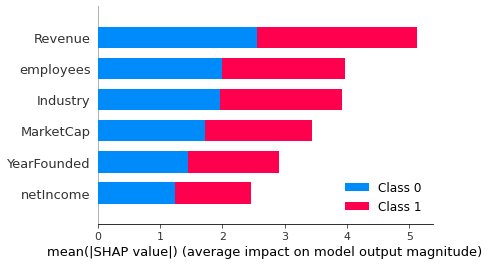

In [183]:
# Оцениваем важность фичей для модели LightGBM
import shap

shap_test = shap.TreeExplainer(best_lgb_clf.fit(X, y)).shap_values(X_new)
shap.summary_plot(shap_test, X,
                      max_display=25, plot_size=None)

[LightGBM] [Warning] feature_fraction is set=0.5279526075023515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279526075023515
[LightGBM] [Warning] lambda_l1 is set=4.6515862423812214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6515862423812214e-07
[LightGBM] [Warning] bagging_fraction is set=0.8715136747236529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715136747236529
[LightGBM] [Warning] lambda_l2 is set=6.4204385396103e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4204385396103e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


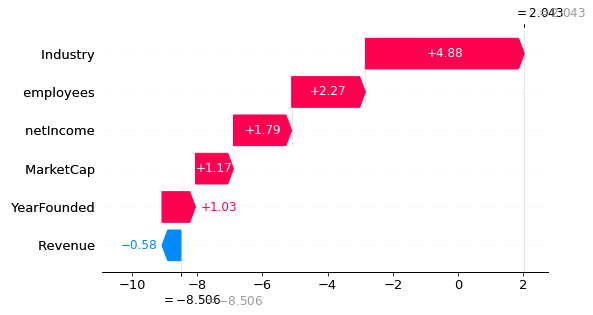

In [184]:
explainer = shap.Explainer(best_lgb_clf.fit(X, y), X)
shap_values = explainer(X_new)

shap.plots.waterfall(shap_values[0])

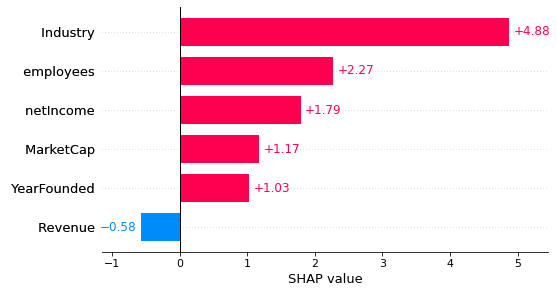

In [185]:
shap.plots.bar(shap_values[0])

In [94]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

AttributeError: 'Explanation' object has no attribute 'cohorts'